Import Libraries


In [1]:
import json
import json
import random
import cv2
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

Fix JSON File

In [ ]:
def fix_json_format(file_path):
    try:
        with open(file_path, 'r') as file:
            content = file.read()
            parsed_data = json.loads(content)
        print(f"JSON in '{file_path}' is valid.")
        return parsed_data
    ##json ???

    except json.JSONDecodeError as e:
        print(f"JSONDecodeError in '{file_path}': {e}")
        
        error_location = e.pos
        print(f"Error at position: {error_location}")
        
        fixed_content = fix_json(content)
        
        try:
            parsed_data = json.loads(fixed_content)
            with open(file_path, 'w') as file:
                file.write(fixed_content)
            print(f"Fixed and saved JSON in '{file_path}'.")
            return parsed_data
        except json.JSONDecodeError as e:
            print(f"Unable to fix JSON in '{file_path}': {e}")
            return None

def fix_json(content):
    fixed_content = content.replace("], [", "], [")  
    return fixed_content


##main
file_path = 'annotations.json'
data = fix_json_format(file_path)


JSON in 'annotations.json' is valid.


In [5]:
# print(json.dumps(data[0], indent=4))
classes = set(ann["position"] for ann in data)
print("Classes:", classes)
print("Number of classes:", len(classes))

Classes: {'open_guard2', 'closed_guard2', 'mount2', 'half_guard2', 'turtle1', 'takedown1', 'half_guard1', 'takedown2', '5050_guard', 'back1', 'back2', 'turtle2', 'side_control2', 'open_guard1', 'closed_guard1', 'mount1', 'standing', 'side_control1'}
Number of classes: 18


Visualise 

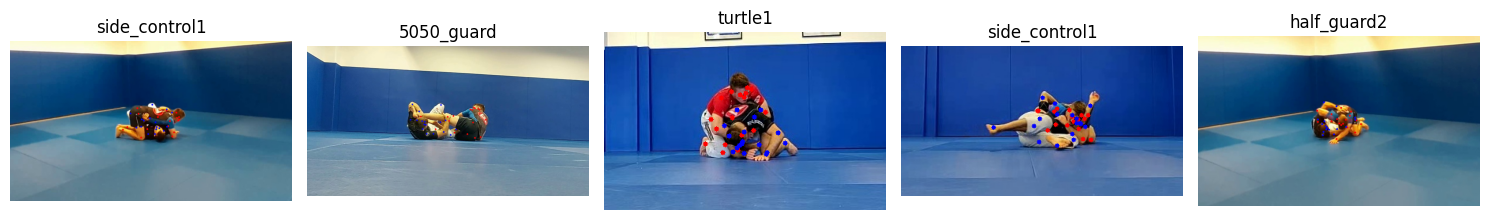

In [2]:
with open('annotations.json') as f:
    annotations = json.load(f)

valid_annotations = [a for a in annotations if "pose1" in a and "pose2" in a]

image_dir = 'images'

def visualize_pose(image_path, pose1, pose2, title):
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Image not found: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for pose, color in zip([pose1, pose2], ['red', 'blue']):
        if pose:
            for point in pose:
                x, y, c = point
                if c > 0.1:  
                    cv2.circle(
                        image, (int(x), int(y)), 3,
                        (255 if color == 'red' else 0, 0, 255 if color == 'blue' else 0),
                        -1
                    )

    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

num_samples = min(5, len(valid_annotations))

if num_samples == 0:
    print("No valid annotations with both pose1 and pose2.")
else:
    samples = random.sample(valid_annotations, num_samples)

    plt.figure(figsize=(15, 10))
    for i, ann in enumerate(samples):
        img_name = ann.get("image", "unknown") + ".jpg"
        image_path = os.path.join(image_dir, img_name)
        plt.subplot(1, num_samples, i + 1)
        visualize_pose(
            image_path,
            ann.get("pose1"),
            ann.get("pose2"),
            ann.get("position", "Unknown")
        )

    plt.tight_layout()
    plt.show()

In [3]:
!{sys.executable} -m pip install requests


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Train-test split

In [21]:
train_anns, temp_anns = train_test_split(valid_annotations, test_size=0.3, random_state=42)

val_anns, test_anns = train_test_split(temp_anns, test_size=0.5, random_state=42)

print(f"Train: {len(train_anns)}, Val: {len(val_anns)}, Test: {len(test_anns)}")

positions = list(set(a["position"] for a in valid_annotations))
position_to_id = {pos: i for i, pos in enumerate(positions)}

def encode_pose(pose):
    return [coord for keypoint in pose for coord in keypoint[:2]]  # Use only x and y


def prepare_data(annotations):
    X = []
    y = []
    for ann in annotations:
        pose1 = encode_pose(ann["pose1"])
        pose2 = encode_pose(ann["pose2"])
        X.append(pose1 + pose2)  
        y.append(position_to_id[ann["position"]])
    return np.array(X, dtype=np.float32), np.array(y)

X_train, y_train = prepare_data(train_anns)
X_val, y_val = prepare_data(val_anns)
X_test, y_test = prepare_data(test_anns)


Train: 53440, Val: 11451, Test: 11452


**Detection-Pose Transformer**
**DETR Architecture**
Detection Transformer (DETR)
LayerNORM added improvement

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class PoseClassifierTransformer(nn.Module):
    def __init__(self, input_dim=34, seq_len=2, d_model=128, nhead=4, num_layers=2, num_classes=6, dropout=0.1):
        super(PoseClassifierTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, d_model)  # Each pose is 17 keypoints → 34 floats
        self.layer_norm1 = nn.LayerNorm(d_model)  # Add LayerNorm after embedding
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layer_norm2 = nn.LayerNorm(d_model)  # Add LayerNorm after transformer output

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Learnable [CLS] token

        self.dropout = nn.Dropout(dropout)  # Dropout before classifier

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = x.view(B, 2, -1)  # [B, 2, 34]
        x = self.embedding(x)  # [B, 2, d_model]
        x = self.layer_norm1(x)  # Apply LayerNorm after embedding

        cls_tokens = self.cls_token.repeat(B, 1, 1)  # [B, 1, d_model]
        x = torch.cat([cls_tokens, x], dim=1)  # [B, 3, d_model]

        x = x.permute(1, 0, 2)  # [seq_len, B, d_model] for Transformer

        # Pass through transformer encoder
        x = self.transformer(x)

        # Take CLS token output and apply LayerNorm
        x = x[0]  # Get the output for the CLS token
        x = self.layer_norm2(x)  # Apply LayerNorm after transformer output

        # Apply dropout before classifier
        x = self.dropout(x)

        # Classifier output
        return self.classifier(x)


In [29]:
# Convert your NumPy arrays into PyTorch datasets
train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val), torch.tensor(y_val)), batch_size=32)
print(X_train.shape)  # Should be (#samples, ?)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PoseClassifierTransformer(num_classes=len(position_to_id)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Val Acc: {acc:.2f}")

(53440, 68)
Epoch 1/10, Loss: 1897.9642, Val Acc: 0.73
Epoch 2/10, Loss: 1134.5061, Val Acc: 0.85
Epoch 3/10, Loss: 904.3958, Val Acc: 0.85
Epoch 4/10, Loss: 751.8756, Val Acc: 0.90
Epoch 5/10, Loss: 659.9383, Val Acc: 0.90
Epoch 6/10, Loss: 585.6155, Val Acc: 0.92
Epoch 7/10, Loss: 527.7392, Val Acc: 0.94
Epoch 8/10, Loss: 466.4850, Val Acc: 0.93
Epoch 9/10, Loss: 475.3960, Val Acc: 0.94
Epoch 10/10, Loss: 449.8213, Val Acc: 0.94


In [30]:
test_loader = DataLoader(TensorDataset(torch.tensor(X_test)), batch_size=1)
model.eval()

inv_position_map = {v: k for k, v in position_to_id.items()}

predictions = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb[0].to(device)  # xb is a tuple (input_tensor,)
        xb = xb.view(1, 2, -1)  # Optional: reshape to [batch_size, 2, 34] if needed by model
        pred = model(xb)
        label = pred.argmax(dim=1).item()
        predictions.append(inv_position_map[label])


In [31]:
def visualize_predictions(samples, model, device, position_to_id, image_dir):
    model.eval()
    inv_position_map = {v: k for k, v in position_to_id.items()}

    plt.figure(figsize=(18, 6))
    for i, ann in enumerate(samples):
        pose1 = ann["pose1"]
        pose2 = ann["pose2"]
        img_name = ann["image"] + ".jpg"
        image_path = os.path.join(image_dir, img_name)

        input_vec = encode_pose(pose1) + encode_pose(pose2)
        input_tensor = torch.tensor(input_vec, dtype=torch.float32).unsqueeze(0).to(device)
        pred = model(input_tensor)
        pred_label = pred.argmax(dim=1).item()

        gt_label = ann["position"]
        pred_label_name = inv_position_map[pred_label]

        title = f"GT: {gt_label}\nPred: {pred_label_name}"

        plt.subplot(1, len(samples), i + 1)
        visualize_pose(image_path, pose1, pose2, title)

    plt.tight_layout()
    plt.show()

In [32]:
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=32)

def compute_test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return correct / total if total > 0 else 0.0

test_acc = compute_test_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 94.02%


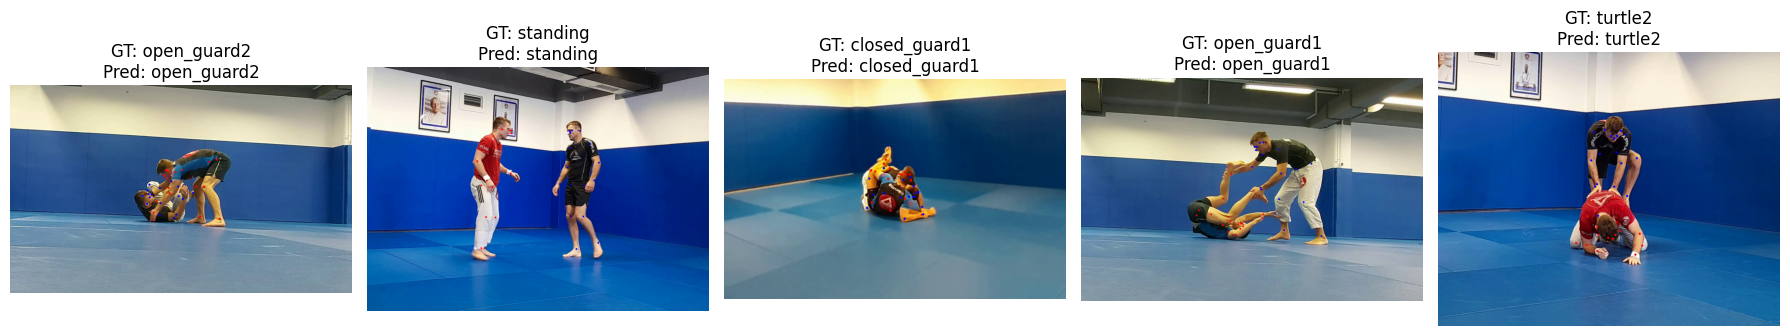

In [33]:
num_samples = 5
test_samples = random.sample(test_anns, min(num_samples, len(test_anns)))

visualize_predictions(test_samples, model, device, position_to_id, image_dir)
